In [1]:
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
%matplotlib inline
import seaborn as sns

import sys,os,pdb,copy,pickle
from importlib import reload
import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp
import database
db = database.db

import change_point_analysis as cpa
import change_point_plot as cpp

In [266]:
data_dir_full=db.query('animal_name=="e13_26m1"')['data_dir_full'].iloc[0]

In [3]:
# load data
mat_to_return=prep.load_stuff(data_dir_full)
# sessionPulses=mat_to_return['sessionPulses']
# filtered = mat_to_return['filtered']
behavior=mat_to_return['behavior']
# ripples = mat_to_return['ripples']


prep_res = dpp.load_spk_beh_df(data_dir_full,force_reload=False,extra_load={})
spk_beh_df=prep_res['spk_beh_df']
cell_cols_d = prep_res['cell_cols_d']
beh_df = prep_res['beh_df']
beh_df_d,beh_df=dpp.group_into_trialtype(beh_df)
spike_trains = prep_res['spike_trains']

In [4]:
# get place fields!!!!
import place_field_analysis as pf
reload(pf)

cell_cols = cell_cols_d['pyr']
spk_beh_df = dpp.add_lin_binned(spk_beh_df,nbins=100)
_,spk_beh_df=dpp.group_into_trialtype(spk_beh_df)
fr_map_d,count_d,occu_d = pf.ratemap_from_spk_beh_df_alltrialtype(spk_beh_df,cell_cols,speed_thresh=1.,nbins=100,smth_in_bin=2.5)


# get fields
fr_map_peaks_d = {}
field_res_d = {}
min_rate=0.6
for key in fr_map_d.keys():

    fr_map = fr_map_d[key]
    count = count_d[key]
    occu = occu_d[key]
    field_res_d[key] =pf.get_field_peaks_one_trialtype(fr_map,count,occu,min_rate=min_rate)
    


In [5]:
# get field params!!!!!
reload(pa)
gpb = spk_beh_df.groupby('trial_type')
field_params_all = {}
fr_map_trial_all = {}
X_all = {}
X_all_norm = {}
for key,val in gpb:
    fr_map_trial,count_trial,occu_trial = pa.get_fr_map_trial_onegroup(val,cell_cols_d['pyr'],gauss_width=2.5,order=['smooth','divide'],n_lin_bins=100,speed_thresh=1)
    fr_map_trial_df = pf.fr_map_trial_to_df(fr_map_trial,cell_cols_d['pyr'])
    
    field_params_trial=pf.get_field_params_trial(fr_map_trial_df,field_res_d[key]['all_fields'])
    fr_map_trial_all[key] = fr_map_trial_df
    field_params_all[key]=field_params_trial
    X_all[key] = field_params_trial.loc['fr']
    
    X_all_norm[key] = X_all[key] / X_all[key].max(axis=1).values[:,None]
    

cant format into a dataframe
cant format into a dataframe


In [6]:
import ruptures as rpt


from pandarallel import pandarallel

In [7]:
%%time

pen_l = [0.1,0.3,0.6]
X_norm_pwc_d_allpen = {}
min_size = 1
for pen in pen_l:
    X_norm_pwc_d = {}
    for k,X in X_all.items():
        %time X_norm_pwc,cpts = cpa.predict_from_cpts_wrapper_allrows(X,pen,min_size=min_size)
        X_norm_pwc_d[k] = X_norm_pwc
    X_norm_pwc_d_allpen[pen] = X_norm_pwc_d
X_to_be_analyzed = {'raw':X_all_norm}
X_to_be_analyzed.update(X_norm_pwc_d_allpen)

INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
CPU times: user 145 ms, sys: 522 ms, total: 667 ms
Wall time: 1.67 s
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
CPU times: user 160 ms, sys: 527 ms, total: 688 ms
Wall time: 1.78 s
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
CPU times: user 179 ms, sys: 513 ms, total: 692 ms
Wall time: 1.96 s
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
CPU times: user 160 ms, sys: 529 ms, total: 689 ms
Wall time: 2.26 s
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
CPU times

In [8]:
subdb = db.query('animal_name=="e13_26m1"|animal_name=="e15_13f1"')

In [78]:
%%time
changes_df_l = {}
sig_l={}
cdf_l = {}
for ii,ddf in enumerate(subdb['data_dir_full']):
    fn = os.path.join(ddf,'py_data','switch_analysis','switch_res.p')
    res = pickle.load(open(fn,'rb'))
    changes_df_l[ii]=res['changes_df']
    sig_l[ii]=res['sig']
    cdf_l[ii] = res['cdf']

CPU times: user 48.2 s, sys: 453 ms, total: 48.7 s
Wall time: 48.6 s


In [19]:
changes_df_all = pd.concat(changes_df_l,axis=0)

In [75]:
sig_l_all = pd.concat(sig_l,axis=0).astype('boolean').astype('Int64')


In [80]:
cdf_l_all = pd.concat(cdf_l,axis=0)

In [85]:
sig_l_all_val = sig_l_all.values

In [86]:
sig_l_all_val[cdf_l_all<0.5] = -sig_l_all_val[cdf_l_all<0.5]

In [88]:
sig_l_all = pd.DataFrame(sig_l_all_val,index=sig_l_all.index,columns=sig_l_all.columns)

In [138]:
onoff = -1
on_each_session = changes_df_all.groupby(level=(0,1,2,3,4,5)).apply(lambda x:(x==onoff).sum(axis=0))
task_index = 0
# on_each_session.loc[(slice(None),task_index),:]

In [139]:
ratio_on_alltasks_alltrialtypes_d = {}
for task_index in [0,1]:
    on_numbers_onetask_alltrialtypes = on_each_session.loc[(slice(None),task_index),:].groupby(level=(3,4,5)).sum()
    changes_df_onehyperparm_onetask_alltrialtypes = changes_df_all.loc[(slice(None),task_index,slice(None),'raw','switch_magnitude',0),:]

    tot_neurons_per_trial_onetask_alltrialtypes = changes_df_onehyperparm_onetask_alltrialtypes.notna().sum(axis=0)
    ratio_on_onetask_alltrialtypes = on_numbers_onetask_alltrialtypes / tot_neurons_per_trial_onetask_alltrialtypes
    ratio_on_alltasks_alltrialtypes_d[task_index] = ratio_on_onetask_alltrialtypes

In [132]:
ratio_on_alltasks_alltrialtypes_d[0]

1         2         3         4         5   \
0.1 high_thresh      0.3  0.0  0.049378  0.049378  0.047056  0.043047   
                     0.4  0.0  0.047689  0.046212  0.044313  0.041781   
                     0.5  0.0  0.040304  0.040726  0.039882  0.037561   
                     0.6  0.0  0.032918  0.033973  0.034606  0.031652   
                     0.7  0.0  0.028065  0.028698  0.029542  0.026377   
    switch_magnitude 0.0  0.0  0.105296  0.106141  0.090736  0.109939   
                     0.1  0.0  0.105296  0.106141  0.090736  0.109939   
                     0.2  0.0  0.105296  0.106141  0.090525  0.109306   
                     0.3  0.0  0.103397  0.100654  0.084828  0.103397   
                     0.4  0.0  0.088204  0.083351  0.073855  0.085672   
                     0.5  0.0  0.069846  0.067314  0.060772  0.067736   
                     0.6  0.0  0.049166  0.047267  0.046423  0.048533   
0.3 high_thresh      0.3  0.0  0.019624  0.022368  0.024267  0.020890   
                     0.4  0.0  0.019624  0.022368  0.024267  0.020890   
                     0.5  0.0  0.019624  0.022157  0.024267  0.020679   
                     0.6  0.0  0.019624  0.022157  0.023845  0.020468   
                     0.7  0.0  0.019413  0.021735  0.023845  0.020046   
    switch_magnitude 0.0  0.0  0.031230  0.037983  0.041992  0.046212   
                     0.1  0.0  0.031230  0.037983  0.041992  0.046212   
                     0.2  0.0  0.031230  0.037983  0.041992  0.046212   
                     0.3  0.0  0.031230  0.037983  0.041992  0.046212   
                     0.4  0.0  0.031230  0.037983  0.041992  0.044946   
                     0.5  0.0  0.031230  0.037139  0.041359  0.040726   
                     0.6  0.0  0.031019  0.033340  0.036084  0.035240   
0.6 high_thresh      0.3  0.0  0.001688  0.005064  0.008863  0.006963   
                     0.4  0.0  0.001688  0.005064  0.008863  0.006963   
                     0.5  0.0  0.001688  0.005064  0.008863  0.006963   
                     0.6  0.0  0.001688  0.005064  0.008863  0.006963   
                     0.7  0.0  0.001688  0.005064  0.008863  0.006963   
    switch_magnitude 0.0  0.0  0.001899  0.006330  0.012028  0.012450   
                     0.1  0.0  0.001899  0.006330  0.012028  0.012450   
                     0.2  0.0  0.001899  0.006330  0.012028  0.012450   
                     0.3  0.0  0.001899  0.006330  0.012028  0.012450   
                     0.4  0.0  0.001899  0.006330  0.012028  0.012450   
                     0.5  0.0  0.001899  0.006330  0.012028  0.012450   
                     0.6  0.0  0.001899  0.006330  0.011817  0.011395   
raw high_thresh      0.3  0.0  0.085883  0.092636  0.087782  0.084617   
                     0.4  0.0  0.064360  0.067947  0.063516  0.066892   
                     0.5  0.0  0.048322  0.050011  0.046001  0.049378   
                     0.6  0.0  0.035240  0.035662  0.035451  0.034606   
                     0.7  0.0  0.026799  0.026799  0.027221  0.027432   
    switch_magnitude 0.0  0.0  0.499894  0.477105  0.472463  0.490610   
                     0.1  0.0  0.337202  0.318000  0.314834  0.337202   
                     0.2  0.0  0.227685  0.223043  0.212492  0.229795   
                     0.3  0.0  0.152564  0.151509  0.145389  0.161848   
                     0.4  0.0  0.101920  0.101498  0.094746  0.110361   
                     0.5  0.0  0.067736  0.064360  0.060561  0.071534   
                     0.6  0.0  0.044946  0.041359  0.040093  0.045579   

                                6         7         8         9         10  \
0.1 high_thresh      0.3  0.044313  0.037772  0.042203  0.046212  0.031968   
                     0.4  0.043047  0.036295  0.040515  0.044313  0.029998   
                     0.5  0.040304  0.032285  0.038194  0.039671  0.027589   
                     0.6  0.035451  0.027432  0.032707  0.034817  0.025838   
                     0.7  0.031863  0.023423  0.028065  0.0

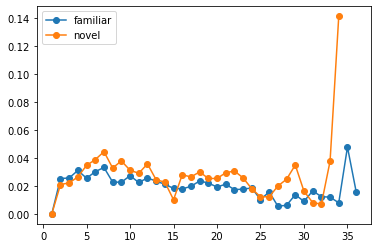

In [140]:
ratio_on_alltasks_alltrialtypes_d[0].median(axis=0).plot(marker='o',label='familiar')
ratio_on_alltasks_alltrialtypes_d[1].median(axis=0).plot(marker='o',label='novel')
plt.legend()


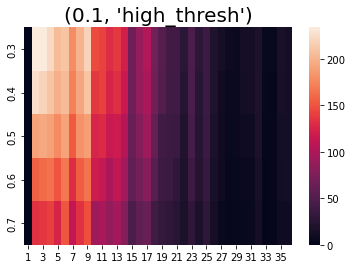

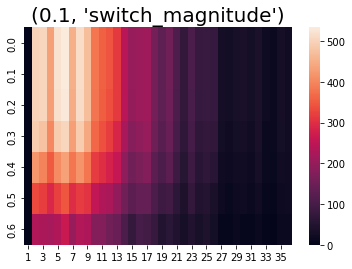

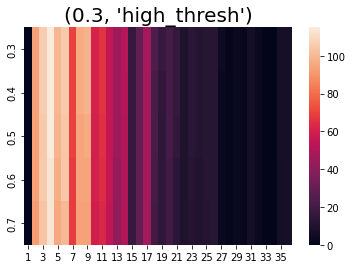

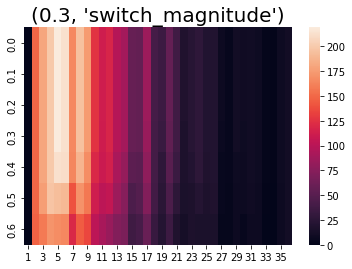

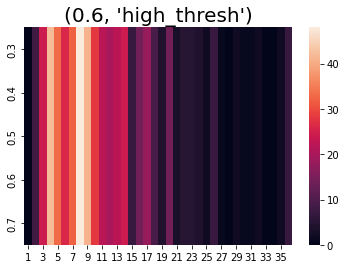

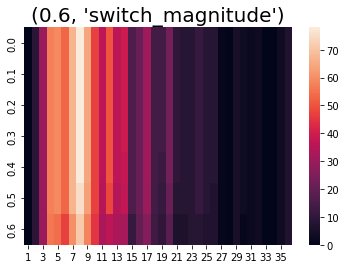

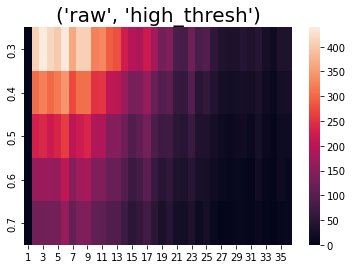

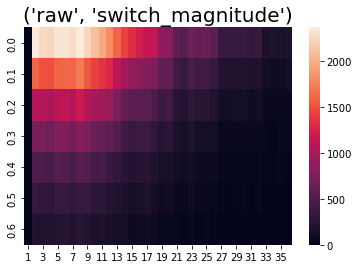

In [57]:
%matplotlib inline
gpb = on_numbers_onetask_alltrialtypes.groupby(level=(0,1))
for k,val in gpb:
    plt.figure()
    ax=sns.heatmap(val.droplevel((0,1)))
    ax.set(ylabel='')
    ax.set_title(k)

In [141]:
ratio_on_onetask_alltrialtypes = ratio_on_alltasks_alltrialtypes_d[0]

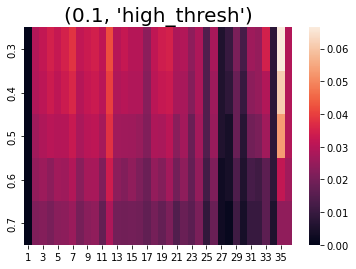

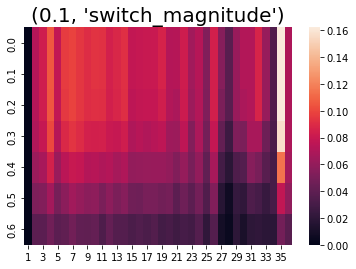

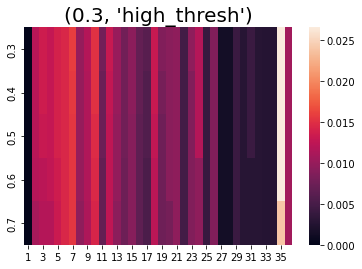

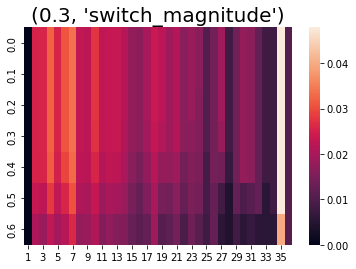

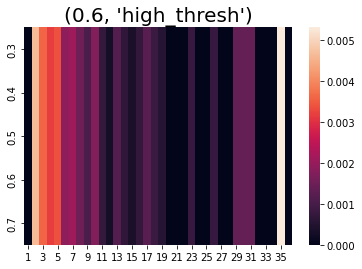

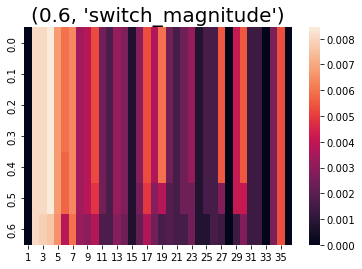

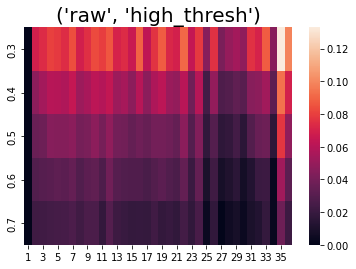

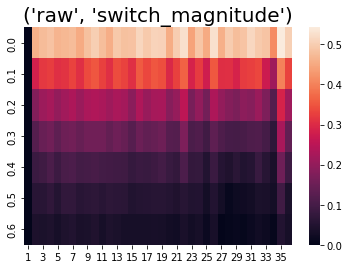

In [142]:
%matplotlib inline
gpb = ratio_on_onetask_alltrialtypes.groupby(level=(0,1))
for k,val in gpb:
    plt.figure()
    ax=sns.heatmap(val.droplevel((0,1)))
    ax.set(ylabel='')
    ax.set_title(k)

In [148]:
sig_ratio_alltask_alltrialtypes_d = {}
sig_on_counts_alltask_alltrialtypes_d = {}
onoff_d = {1:'on',-1:'off'}
for task_index in [0,1]:
    sig_on_counts_onetask_alltrialtypes = sig_l_all.loc[(slice(None),task_index),onoff_d[onoff]].groupby(level=(3,4,5)).apply(lambda x:(x==1).sum(axis=0))
    sig_on_counts_alltask_alltrialtypes_d[task_index] = sig_on_counts_onetask_alltrialtypes
    tot_session_per_trial_onetask_alltrialtypes = sig_l_all.loc[(slice(None),task_index,slice(None),'raw','switch_magnitude',0.0),onoff_d[onoff]]

    tot_session_per_trial_onetask_alltrialtypes = tot_session_per_trial_onetask_alltrialtypes.notna().sum(axis=0)

    sig_ratio_onetask_alltrialtypes = sig_on_counts_onetask_alltrialtypes / tot_session_per_trial_onetask_alltrialtypes
    sig_ratio_alltask_alltrialtypes_d[task_index] = sig_ratio_onetask_alltrialtypes

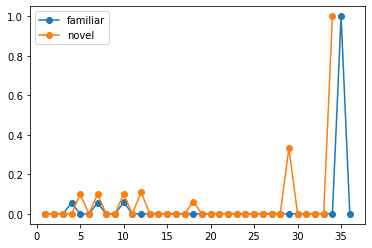

In [144]:
sig_ratio_alltask_alltrialtypes_d[0].median(axis=0).plot(marker='o',label='familiar')
sig_ratio_alltask_alltrialtypes_d[1].median(axis=0).plot(marker='o',label='novel')
plt.legend()


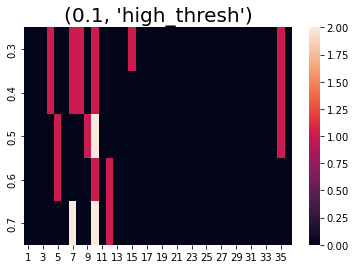

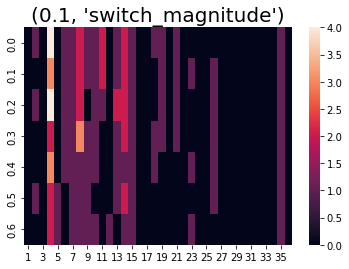

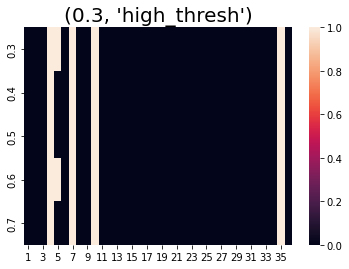

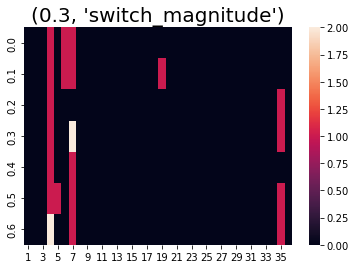

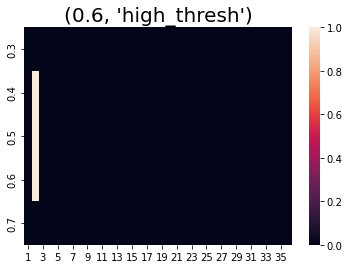

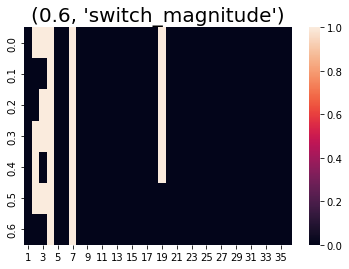

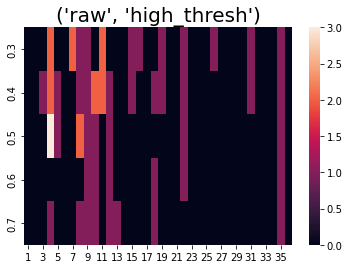

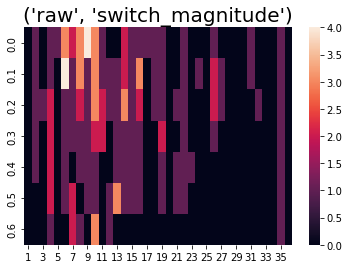

In [149]:
%matplotlib inline
sig_on_counts_onetask_alltrialtypes = sig_on_counts_alltask_alltrialtypes_d[0]
gpb = sig_on_counts_onetask_alltrialtypes.groupby(level=(0,1))
for k,val in gpb:
    plt.figure()
    ax=sns.heatmap(val.droplevel((0,1)))
    ax.set(ylabel='')
    ax.set_title(k)

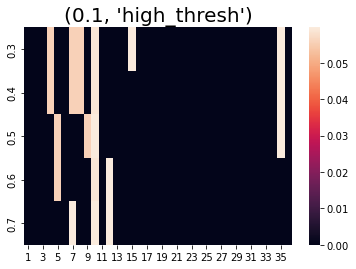

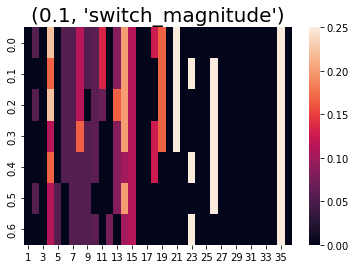

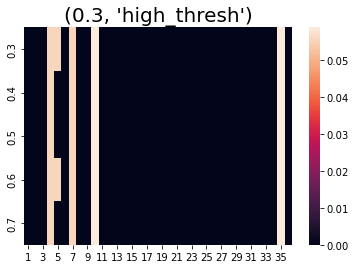

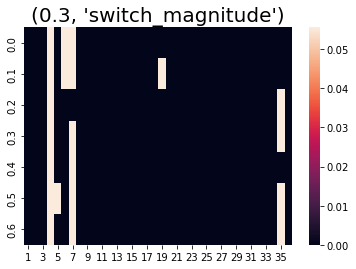

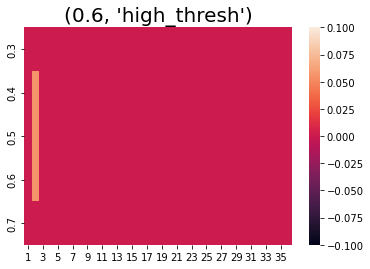

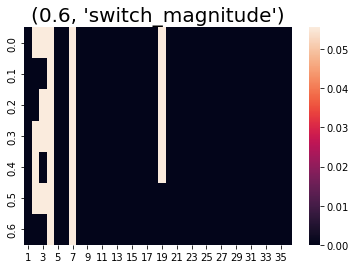

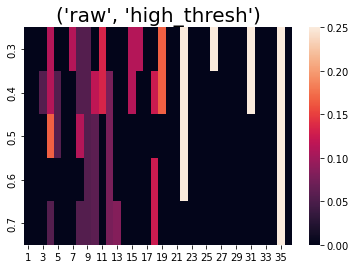

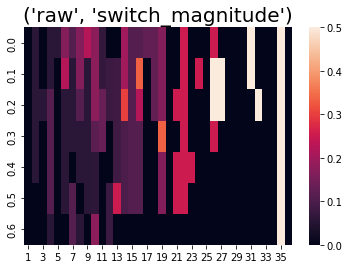

In [147]:
%matplotlib inline
sig_ratio_onetask_alltrialtypes = sig_ratio_alltask_alltrialtypes_d[0]
gpb = sig_ratio_onetask_alltrialtypes.groupby(level=(0,1))
for k,val in gpb:
    plt.figure()
    ax=sns.heatmap(val.droplevel((0,1)),vmax=np.quantile(val,0.95))
    ax.set(ylabel='')
    ax.set_title(k)

# illustrate the pipeline

In [150]:
# structured vs random

In [155]:
fn = os.path.join(data_dir_full,'py_data','instability','contiguous_instability.p')
contiguous_instability = pickle.load(open(fn,'rb'))

In [159]:
contiguous_instability['instability_df_d'][0,0]['issig']

1      2      3      4      5      6
    lin_binned                                          
1   7           False   True   True   True   True   True
3   3            True   True   True   True   True   True
27  1           False   True   True   True   True   True
    7           False  False  False  False  False  False
29  2           False   True   True   True   True   True
...               ...    ...    ...    ...    ...    ...
478 1           False   True   True   True   True   True
    4           False   True   True   True   True   True
479 6           False  False  False  False  False  False
480 3           False  False  False  False  False  False
    8           False  False  False  False  False  False

[775 rows x 6 columns]

<AxesSubplot:xlabel='trial', ylabel='Firing Rate'>

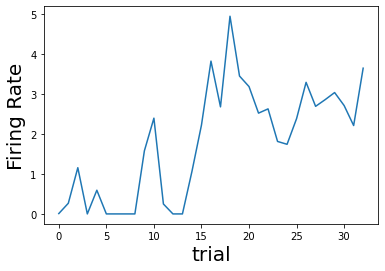

In [168]:
 X_all[0,0].loc[3,0].T.plot(xlabel='trial',ylabel='Firing Rate')

In [206]:
random_signal = X_all_norm[0,0].loc[27,1]

In [169]:
signal =  X_all[0,0].loc[3,0]

signal = signal.values / signal.max()

In [172]:
signal

array([0.0017679 , 0.05385746, 0.23377542, 0.        , 0.11986565,
       0.        , 0.        , 0.        , 0.        , 0.31944361,
       0.48440197, 0.05015596, 0.        , 0.        , 0.21514222,
       0.44939799, 0.77296397, 0.54159595, 1.        , 0.69748088,
       0.64413657, 0.50983694, 0.53135306, 0.36660196, 0.35217114,
       0.48206096, 0.66560275, 0.54423207, 0.57789534, 0.61397447,
       0.54818814, 0.44710863, 0.73721646])

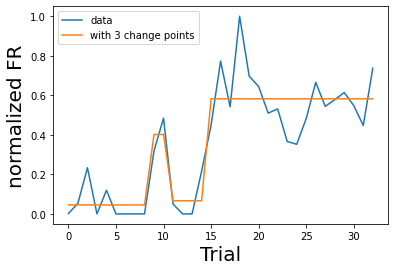

In [187]:
ax=X_all_norm[0,0].loc[3].T.plot(xlabel='Trial',ylabel='normalized FR')
X_norm_pwc_d_allpen[0.1][0,0].loc[3].T.plot(ax=ax)
plt.legend(['data','with 3 change points'])


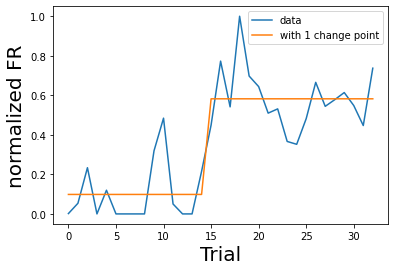

In [189]:
ax=X_all_norm[0,0].loc[3].T.plot(xlabel='Trial',ylabel='normalized FR')
X_norm_pwc_d_allpen[0.6][0,0].loc[3].T.plot(ax=ax)
plt.legend(['data','with 1 change point'])


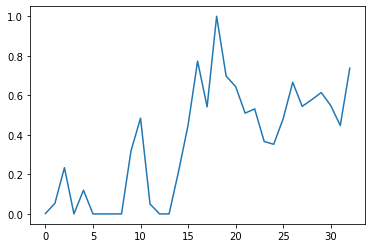

In [230]:
signal =  X_all[0,0].loc[3,0]

signal = signal.values / signal.max()
plt.plot(signal)

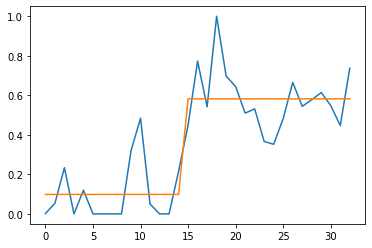

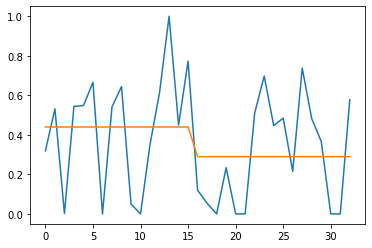

In [233]:
signal_pwc = cpa.predict_from_cpts_wrapper(signal,1,model_type=rpt.Dynp)[0]

plt.plot(signal)
plt.plot(signal_pwc)

signal_shuffle=np.random.permutation(signal)
signal_shuffle_pwc = cpa.predict_from_cpts_wrapper(signal_shuffle,1,model_type=rpt.Dynp)[0]
plt.figure()
plt.plot(signal_shuffle)
plt.plot(signal_shuffle_pwc)

In [219]:
random_signal_pwc = cpa.predict_from_cpts_wrapper(random_signal.values,1,model_type=rpt.Dynp)[0]

ax=random_signal.plot()
ax.plot(random_signal_pwc)

random_signal_shuffle=np.random.permutation(random_signal.values)
random_signal_pwc = cpa.predict_from_cpts_wrapper(random_signal_shuffle,1,model_type=rpt.Dynp)[0]

plt.plot(random_signal_shuffle)
plt.plot(random_signal_pwc)

# distribution of instability

In [244]:
instability_res['ratio_d']

{(0, 0.0): 0.5161290322580645,
 (0, 1.0): 0.5425531914893617,
 (1, 0.0): 0.5111111111111111,
 (1, 1.0): 0.4827586206896552}

In [245]:
subdb=db.query('owner=="roman"|owner=="ipshita"')
subdb=copy.copy(subdb)
import logging
from collections import OrderedDict
instability_res_d = OrderedDict()
ratio_l = []
failed_l=[]
for index,row in subdb.iterrows():
    data_dir_full=row['data_dir_full']
    res_to_save_dir = os.path.join(data_dir_full,'py_data','instability')
    res_to_save_name = f'contiguous_instability'
    res_to_save_fn  = os.path.join(res_to_save_dir,res_to_save_name+'.p')
    try:
        instability_res = pickle.load(open(res_to_save_fn,'rb'))    
        ratio_l.append(instability_res['ratio_d'].values())
        instability_res_d[row['sess_name']] = instability_res
    except:
        logging.exception('')
        ratio_l.append([])
        failed_l.append(row)
subdb['ratio']= ratio_l


# all_instability_ratio= np.concatenate([list(x) for x in subdb['ratio'].values])
all_instability_ratio= np.array([np.mean(list(x)) for x in subdb['ratio'].values])

all_instability_by_owner = subdb.groupby('owner')['ratio'].apply(lambda val:np.concatenate([list(x) for x in val.values]))

ERROR:root:
Traceback (most recent call last):
  File "/tmp/ipykernel_263915/1781498001.py", line 14, in <cell line: 8>
    instability_res = pickle.load(open(res_to_save_fn,'rb'))
FileNotFoundError: [Errno 2] No such file or directory: '/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m2/e16_3m2_211212/py_data/instability/contiguous_instability.p'


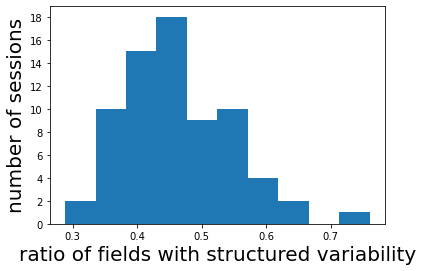

In [258]:
from matplotlib.ticker import MaxNLocator
fig,ax=plt.subplots()
ax.hist(all_instability_ratio)
ax.set_ylabel('number of sessions')
ax.set_xlabel('ratio of fields with structured variability')
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

# missing cases

<AxesSubplot:xlabel='Trial', ylabel='FR'>

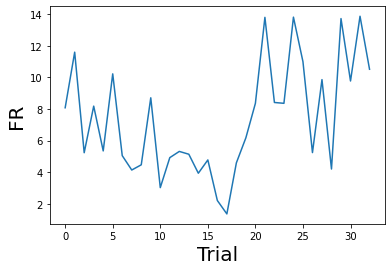

In [264]:
X_all[0,0].loc[480].T.plot(ylabel='FR',xlabel='Trial',legend=False)

# nmf stuff

In [267]:
import nmf_one_session as nos
from itertools import product
reload(nos)
condition_df = {'do_normalize':[True],'speed_thresh':[1],'israte':[True]}
condition_df = pd.DataFrame(list(product(*condition_df.values())),columns=list(condition_df.keys()))
n_compo = 4
nmf_res_d = {}

for _,combo in condition_df.iterrows():
    do_normalize,speed_thresh,israte = combo['do_normalize'],combo['speed_thresh'],combo['israte']
    res_to_save_name = f'nmf_{n_compo}_normalize_{do_normalize}_speedthresh_{int(speed_thresh)}_rate_{israte}'
    nmf_res_d[tuple(combo.values)]=nos.nmf_one_session(data_dir_full,kwargs_={'n_compo':n_compo,'doplots':False,'n_clust':6,'do_normalize':do_normalize,'force_reload':False,'dosave':False,'speed_thresh':speed_thresh,'res_to_save_name':res_to_save_name,'israte':israte})



<module 'sys' (built-in)>
<module 'sys' (built-in)>
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/nmf/nmf_4_normalize_True_speedthresh_1_rate_True.p already exists! Loading--


In [268]:
donormalize=True
X_restacked_df_d=nmf_res_d[(donormalize,1,True)]['X_normed_restacked_df_d']
W_df_peaks_only_d=nmf_res_d[(donormalize,1,True)]['W_df_peaks_only_d']

key=(0,1)
X_peaks = X_restacked_df_d[key].loc[W_df_peaks_only_d[key].index]
X = X_peaks
sigma=1
X_peaks_smth = scipy.ndimage.gaussian_filter1d(X_peaks,sigma,axis=1)
X_peaks_smth = pd.DataFrame(X_peaks_smth,index=X_peaks.index,columns=X_peaks.columns)

<AxesSubplot:xlabel='trial', ylabel='lin_binned'>

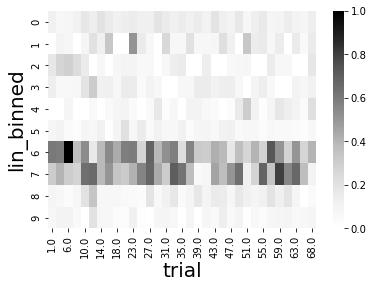

In [284]:
sns.heatmap(X_restacked_df_d[0,0].loc[100],cmap='Greys')

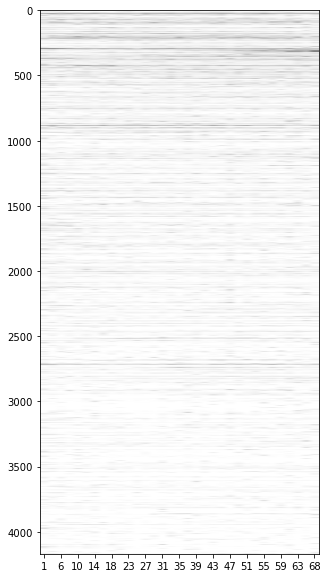

In [278]:
fig,ax=plt.subplots(figsize=(5,10))
ax.imshow(X_restacked_df_d[0,0],cmap='Greys',aspect='auto')
_=ax.set_xticks(np.arange(X_restacked_df_d[0,0].shape[1])[::2])
_=ax.set_xticklabels(X_restacked_df_d[0,0].columns[::2].astype(int))

In [292]:
X_sim_l = cpa.gen_circular_shuffle(X_restacked_df_d[0,0],nrepeats=100)

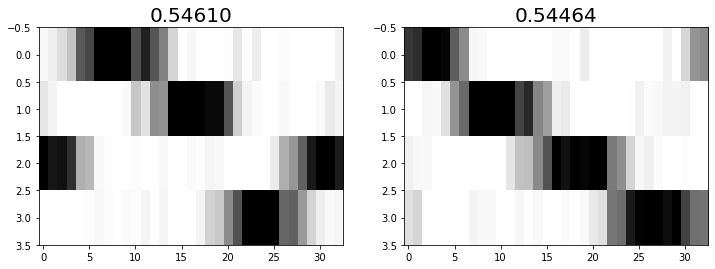

In [289]:
nplots=2
fig,axs=ph.subplots_wrapper(nplots,return_axs=True)
for ii,X_sim in enumerate(X_sim_l):
    W, W_sorted,W_inds, factor_assignment, H_sorted, X_sorted, X_recon_sorted=na.nmf_and_sort(X_sim.values,4)
    # nmfp.plot_wh(W_sorted,H_sorted)
    err_ratio=np.linalg.norm(X_sorted - X_recon_sorted,'fro')**2 / np.linalg.norm(X_recon_sorted,'fro')**2
    axs.ravel()[ii].imshow(H_sorted,aspect='auto',vmax=np.quantile(H_sorted,0.9))
    axs.ravel()[ii].set_title(f'{err_ratio:.05f}')

In [293]:
W, W_sorted,W_inds, factor_assignment, H_sorted, X_sorted, X_recon_sorted=na.nmf_and_sort(X_restacked_df_d[0,0].values,4)
    # nmfp.plot_wh(W_sorted,H_sorted)
true_err_ratio=np.linalg.norm(X_sorted - X_recon_sorted,'fro')**2 / np.linalg.norm(X_recon_sorted,'fro')**2

In [294]:
%%time
err_ratio_shuffle = []
for X_sim in X_sim_l:
    W, W_sorted,W_inds, factor_assignment, H_sorted, X_sorted, X_recon_sorted=na.nmf_and_sort(X_sim.values,4)
    # nmfp.plot_wh(W_sorted,H_sorted)
    err_ratio=np.linalg.norm(X_sorted - X_recon_sorted,'fro')**2 / np.linalg.norm(X_recon_sorted,'fro')**2
    err_ratio_shuffle.append(err_ratio)
err_ratio_shuffle=np.array(err_ratio_shuffle)

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 800 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 800 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 800 reached. Increase it to improve convergence.
  warnings.warn(


CPU times: user 46.9 s, sys: 19 s, total: 1min 5s
Wall time: 16.6 s


CPU times: user 1min 22s, sys: 34.9 s, total: 1min 57s
Wall time: 31.3 s


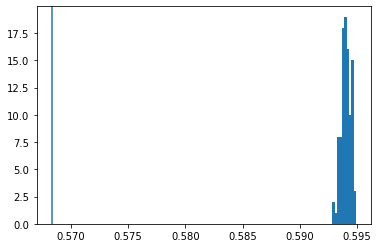

In [300]:
import nmf_test as nt
%time err_shuffle_l,pval = nt.test_co_variation(X_restacked_df_d[0,0],4,n_shuffle=100)

# explain co switching

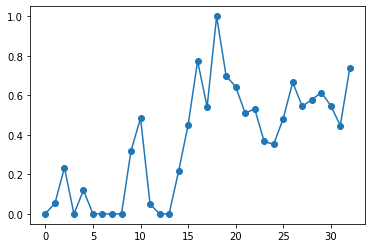

In [351]:
fig,ax=plt.subplots()
ax.plot(signal,marker='o')


/tmp/ipykernel_263915/349932894.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  changes_df_all.loc[0,0,0,'raw','switch_magnitude',0.3,3].T.plot(ax=ax2,color='C1',legend=False,linestyle=':')


<AxesSubplot:>

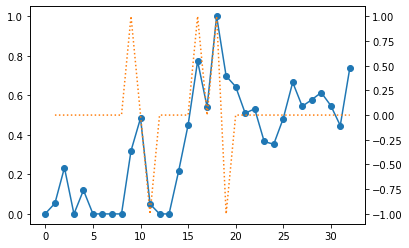

In [318]:
fig,ax=plt.subplots()
ax.plot(signal,marker='o')
ax2=ax.twinx()
changes_df_all.loc[0,0,0,'raw','switch_magnitude',0.3,3].T.plot(ax=ax2,color='C1',legend=False,linestyle=':')

/tmp/ipykernel_263915/2858726528.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  ma=changes_df_all.loc[0,0,0,'raw','switch_magnitude',0.3][8]==1
/tmp/ipykernel_263915/2858726528.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  similar_field=changes_df_all.loc[0,0,0,'raw','switch_magnitude',0.3].loc[ma].index[0]


<AxesSubplot:>

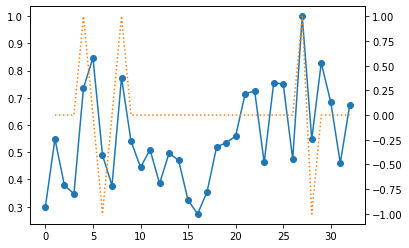

In [325]:
ma=changes_df_all.loc[0,0,0,'raw','switch_magnitude',0.3][8]==1
similar_field=changes_df_all.loc[0,0,0,'raw','switch_magnitude',0.3].loc[ma].index[0]


fig,ax=plt.subplots()
ax.plot(X_all_norm[0,0].loc[similar_field],marker='o')
ax2=ax.twinx()
changes_df_all.loc[0,0,0,'raw','switch_magnitude',0.3,similar_field[0],similar_field[1]].T.plot(ax=ax2,color='C1',legend=False,linestyle=':')

In [327]:
field_res_d[0,0]

{'fr_map_peaks_tested_df':         0     1   2
 1     NaN   NaN NaN
 2     NaN   NaN NaN
 3    32.0   NaN NaN
 27   15.0  77.0 NaN
 29   29.0  77.0 NaN
 ..    ...   ...  ..
 476  45.0   NaN NaN
 477   NaN   NaN NaN
 478   NaN   NaN NaN
 479  65.0   NaN NaN
 480  81.0   NaN NaN
 
 [422 rows x 3 columns],
 'fr_map_peaks': 1       Int64Index([], dtype='int64', name='lin_binned')
 2       Int64Index([], dtype='int64', name='lin_binned')
 3      Int64Index([32], dtype='int64', name='lin_binn...
 27     Int64Index([15, 45, 59, 77], dtype='int64', na...
 29     Int64Index([6, 29, 77], dtype='int64', name='l...
                              ...                        
 476    Int64Index([29, 38, 45], dtype='int64', name='...
 477     Int64Index([], dtype='int64', name='lin_binned')
 478     Int64Index([], dtype='int64', name='lin_binned')
 479    Int64Index([65], dtype='int64', name='lin_binn...
 480    Int64Index([81], dtype='int64', name='lin_binn...
 Length: 422, dtype: object,
 'pvals_df':

<AxesSubplot:xlabel='lin_binned'>

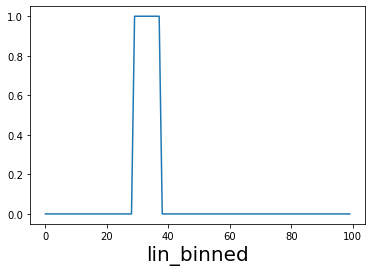

In [340]:
fr_map_trial_df

0    1         2    3    4         5    6         7   \
1.0   0   1.100900  0.0  0.000000  0.0  0.0  0.000000  0.0  0.000000   
      1   1.043072  0.0  0.000000  0.0  0.0  0.000000  0.0  0.000000   
      2   0.956631  0.0  0.000000  0.0  0.0  0.000000  0.0  0.000000   
      3   0.861780  0.0  0.000000  0.0  0.0  0.000000  0.0  0.000000   
      4   0.764116  0.0  0.000000  0.0  0.0  0.000000  0.0  0.000000   
...            ...  ...       ...  ...  ...       ...  ...       ...   
480.0 95  1.022122  0.0  0.482958  0.0  0.0  0.020796  0.0  0.004956   
      96  1.282341  0.0  0.340733  0.0  0.0  0.003685  0.0  0.000577   
      97  1.491263  0.0  0.209272  0.0  0.0  0.000000  0.0  0.000000   
      98  1.643708  0.0  0.117377  0.0  0.0  0.000000  0.0  0.000000   
      99  1.726322  0.0  0.072404  0.0  0.0  0.000000  0.0  0.000000   

                8         9   ...        27        28       29        30  \
1.0   0   0.000000  0.000000  ...  0.000000  0.000000  0.00000  0.000000   
      1   0.000000  0.000000  ...  0.000000  0.000000  0.00000  0.000000   
      2   0.000000  0.000000  ...  0.000000  0.000000  0.00000  0.000000   
      3   0.000000  0.000000  ...  0.000000  0.000000  0.00000  0.000000   
      4   0.000000  0.000000  ...  0.000000  0.000000  0.00000  0.000000   
...            ...       ...  ...       ...       ...      ...       ...   
480.0 95  0.001145  0.000733  ...  0.000587  0.034342  0.00294  0.005733   
      96  0.000000  0.000000  ...  0.000000  0.006597  0.00000  0.001052   
      97  0.000000  0.000000  ...  0.000000  0.001080  0.00000  0.000000   
      98  0.000000  0.000000  ...  0.000000  0.000077  0.00000  0.000000   
      99  0.000000  0.000000  ...  0.000000  0.000000  0.00000  0.000000   

                31        32        33        34        35        36  
1.0   0   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
      1   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
      2   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
      3   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
      4   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
...            ...       ...       ...       ...       ...       ...  
480.0 95  0.000349  0.001748  0.002523  0.010667  0.000109  0.331447  
      96  0.000000  0.000000  0.000000  0.002283  0.000000  0.334545  
      97  0.000000  0.000000  0.000000  0.000000  0.000000  0.312716  
      98  0.000000  0.000000  0.000000  0.000000  0.000000  0.284268  
      99  0.000000  0.000000  0.000000  0.000000  0.000000  0.265498  

[42200 rows x 37 columns]

<AxesSubplot:>

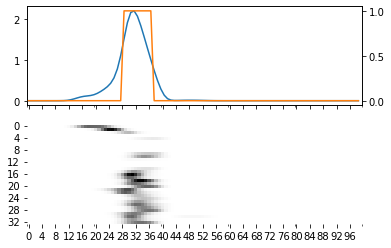

In [350]:
fig,axs=plt.subplots(2,1,sharex=True)
nn=3
ax=fr_map_d[0,0].loc[nn].plot(ax=axs[0])
ax2=ax.twinx()
field_res_d[0,0]['isfield'].loc[nn].astype(int).plot(ax=ax2,color='C1')
sns.heatmap(fr_map_trial_all[0,0].loc[nn].T,ax=axs[1],cmap='Greys',cbar=False)

In [355]:
changes_df_all.loc[0,0,0,'raw','switch_magnitude',0.1].dropna(axis=1)

/tmp/ipykernel_263915/2346656462.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  changes_df_all.loc[0,0,0,'raw','switch_magnitude',0.1].dropna(axis=1)


1   2   3    4    5    6    7    8    9    10  ...   23   24   25   26  \
3   0   0   1  -1  1.0 -1.0  0.0  0.0  0.0  1.0  1.0  ... -1.0  0.0  1.0  1.0   
27  0   0   1  -1  1.0 -1.0  1.0 -1.0  0.0  0.0  1.0  ... -1.0  1.0  0.0 -1.0   
    1   0   0   0  0.0  1.0  0.0  0.0  0.0  1.0 -1.0  ...  1.0  1.0 -1.0  1.0   
29  0   0   1   0 -1.0  1.0  0.0  0.0  0.0  0.0  1.0  ...  1.0  0.0  0.0 -1.0   
    1   0  -1  -1  1.0 -1.0  0.0 -1.0  1.0  1.0 -1.0  ...  0.0  0.0 -1.0  1.0   
...    ..  ..  ..  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
473 0   0   1   1 -1.0  0.0  0.0 -1.0  1.0 -1.0 -1.0  ...  0.0  0.0  0.0  1.0   
475 0   0   1   0 -1.0  0.0  0.0 -1.0  0.0  0.0  0.0  ...  1.0 -1.0  1.0 -1.0   
476 0   0   0   0  0.0  0.0  0.0  0.0  0.0  1.0 -1.0  ...  0.0  0.0  0.0  0.0   
479 0   0   0   0  1.0 -1.0  1.0 -1.0  0.0  0.0  0.0  ... -1.0  0.0  1.0 -1.0   
480 0   0  -1   1 -1.0  1.0 -1.0  0.0  0.0  1.0 -1.0  ...  0.0  1.0 -1.0 -1.0   

        27   28   29   30   31   32  
3   0 -1.0  0.0  0.0  0.0 -1.0  1.0  
27  0 -1.0  1.0  1.0 -1.0  0.0  0.0  
    1  0.0  0.0 -1.0  1.0 -1.0  0.0  
29  0  0.0 -1.0  1.0 -1.0  0.0  0.0  
    1 -1.0 -1.0  0.0  0.0 -1.0  0.0  
...    ...  ...  ...  ...  ...  ...  
473 0  0.0 -1.0  0.0 -1.0  0.0  0.0  
475 0  0.0  1.0 -1.0 -1.0  0.0  1.0  
476 0  0.0  0.0  1.0 -1.0  0.0  0.0  
479 0  0.0  0.0  0.0  0.0  0.0  0.0  
480 0  1.0 -1.0  1.0 -1.0  1.0 -1.0  

[351 rows x 32 columns]

(        on     off
 1   0.0000  0.0000
 2   1.0000  0.4575
 3   0.3875  0.2375
 4   1.0000  0.2175
 5   0.8625  0.9925
 6   0.7100  0.9850
 7   0.0275  0.9000
 8   0.9000  0.2250
 9   0.6400  0.2250
 10  0.1550  0.0075
 11  0.4675  0.3275
 12  0.1275  0.4725
 13  0.0300  0.1375
 14  0.1825  0.0400
 15  0.8525  0.0050
 16  0.0700  0.5175
 17  0.9425  0.8625
 18  0.3100  0.9725
 19  0.7550  0.1300
 20  0.5850  0.6625
 21  0.1525  0.1025
 22  0.1325  0.9900
 23  0.9875  0.0100
 24  0.0375  0.9300
 25  0.8975  0.5250
 26  0.9725  0.9950
 27  0.0775  0.0225
 28  0.0950  0.0725
 29  0.1375  0.9250
 30  0.2375  0.7375
 31  0.0125  0.9950
 32  0.2975  0.5025,
 {'on': 1     0.000000
  2     0.105413
  3     0.059829
  4     0.145299
  5     0.079772
  6     0.074074
  7     0.039886
  8     0.082621
  9     0.071225
  10    0.054131
  11    0.065527
  12    0.054131
  13    0.042735
  14    0.054131
  15    0.082621
  16    0.048433
  17    0.085470
  18    0.059829
  19    0.076923
  20    0.

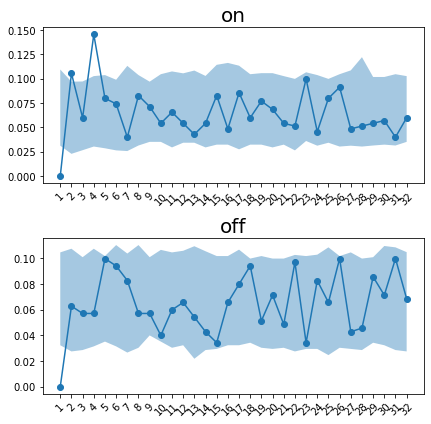

In [358]:
cpa.test_switch_ratio_wrapper(X_norm_pwc_d_allpen[0.1][0,0].iloc[:,min_size:],detect_func=cpa.detect_switch_pwc,alpha=0.05,do_bonf=True,doplots=True,nrepeats=400,switch_magnitude=0.2)




In [361]:
fn = os.path.join(data_dir_full,'py_data','switch_analysis','switch_res.p')
res = pickle.load(open(fn,'rb'))

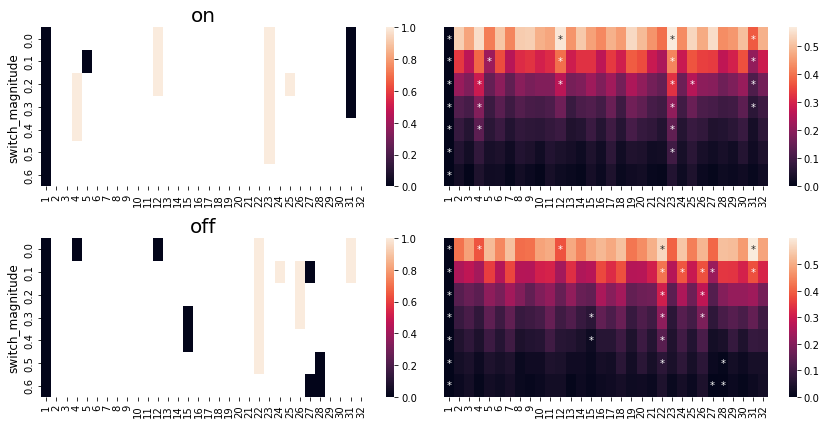

In [369]:
pen='raw'
res['fig'][0,0][pen]['switch_magnitude']

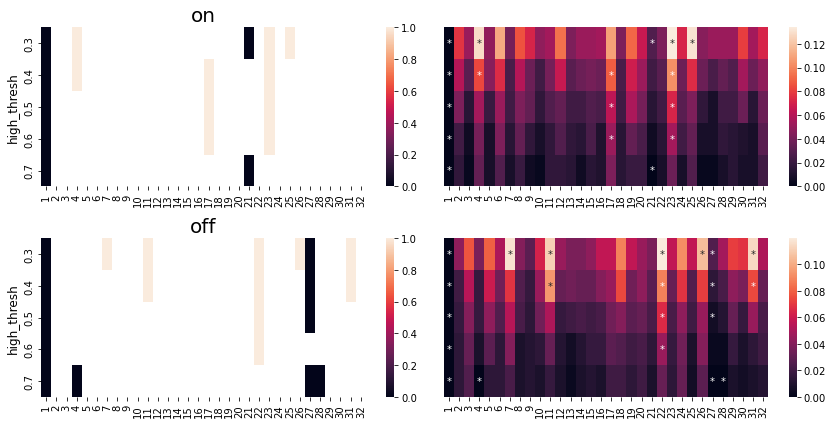

In [371]:
res['fig'][0,0][pen]['high_thresh']

/tmp/ipykernel_263915/2293128117.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  changes=changes_df_all.loc[0].loc[(*trialtype,pen,tosweep_key,tosweep_val),:]


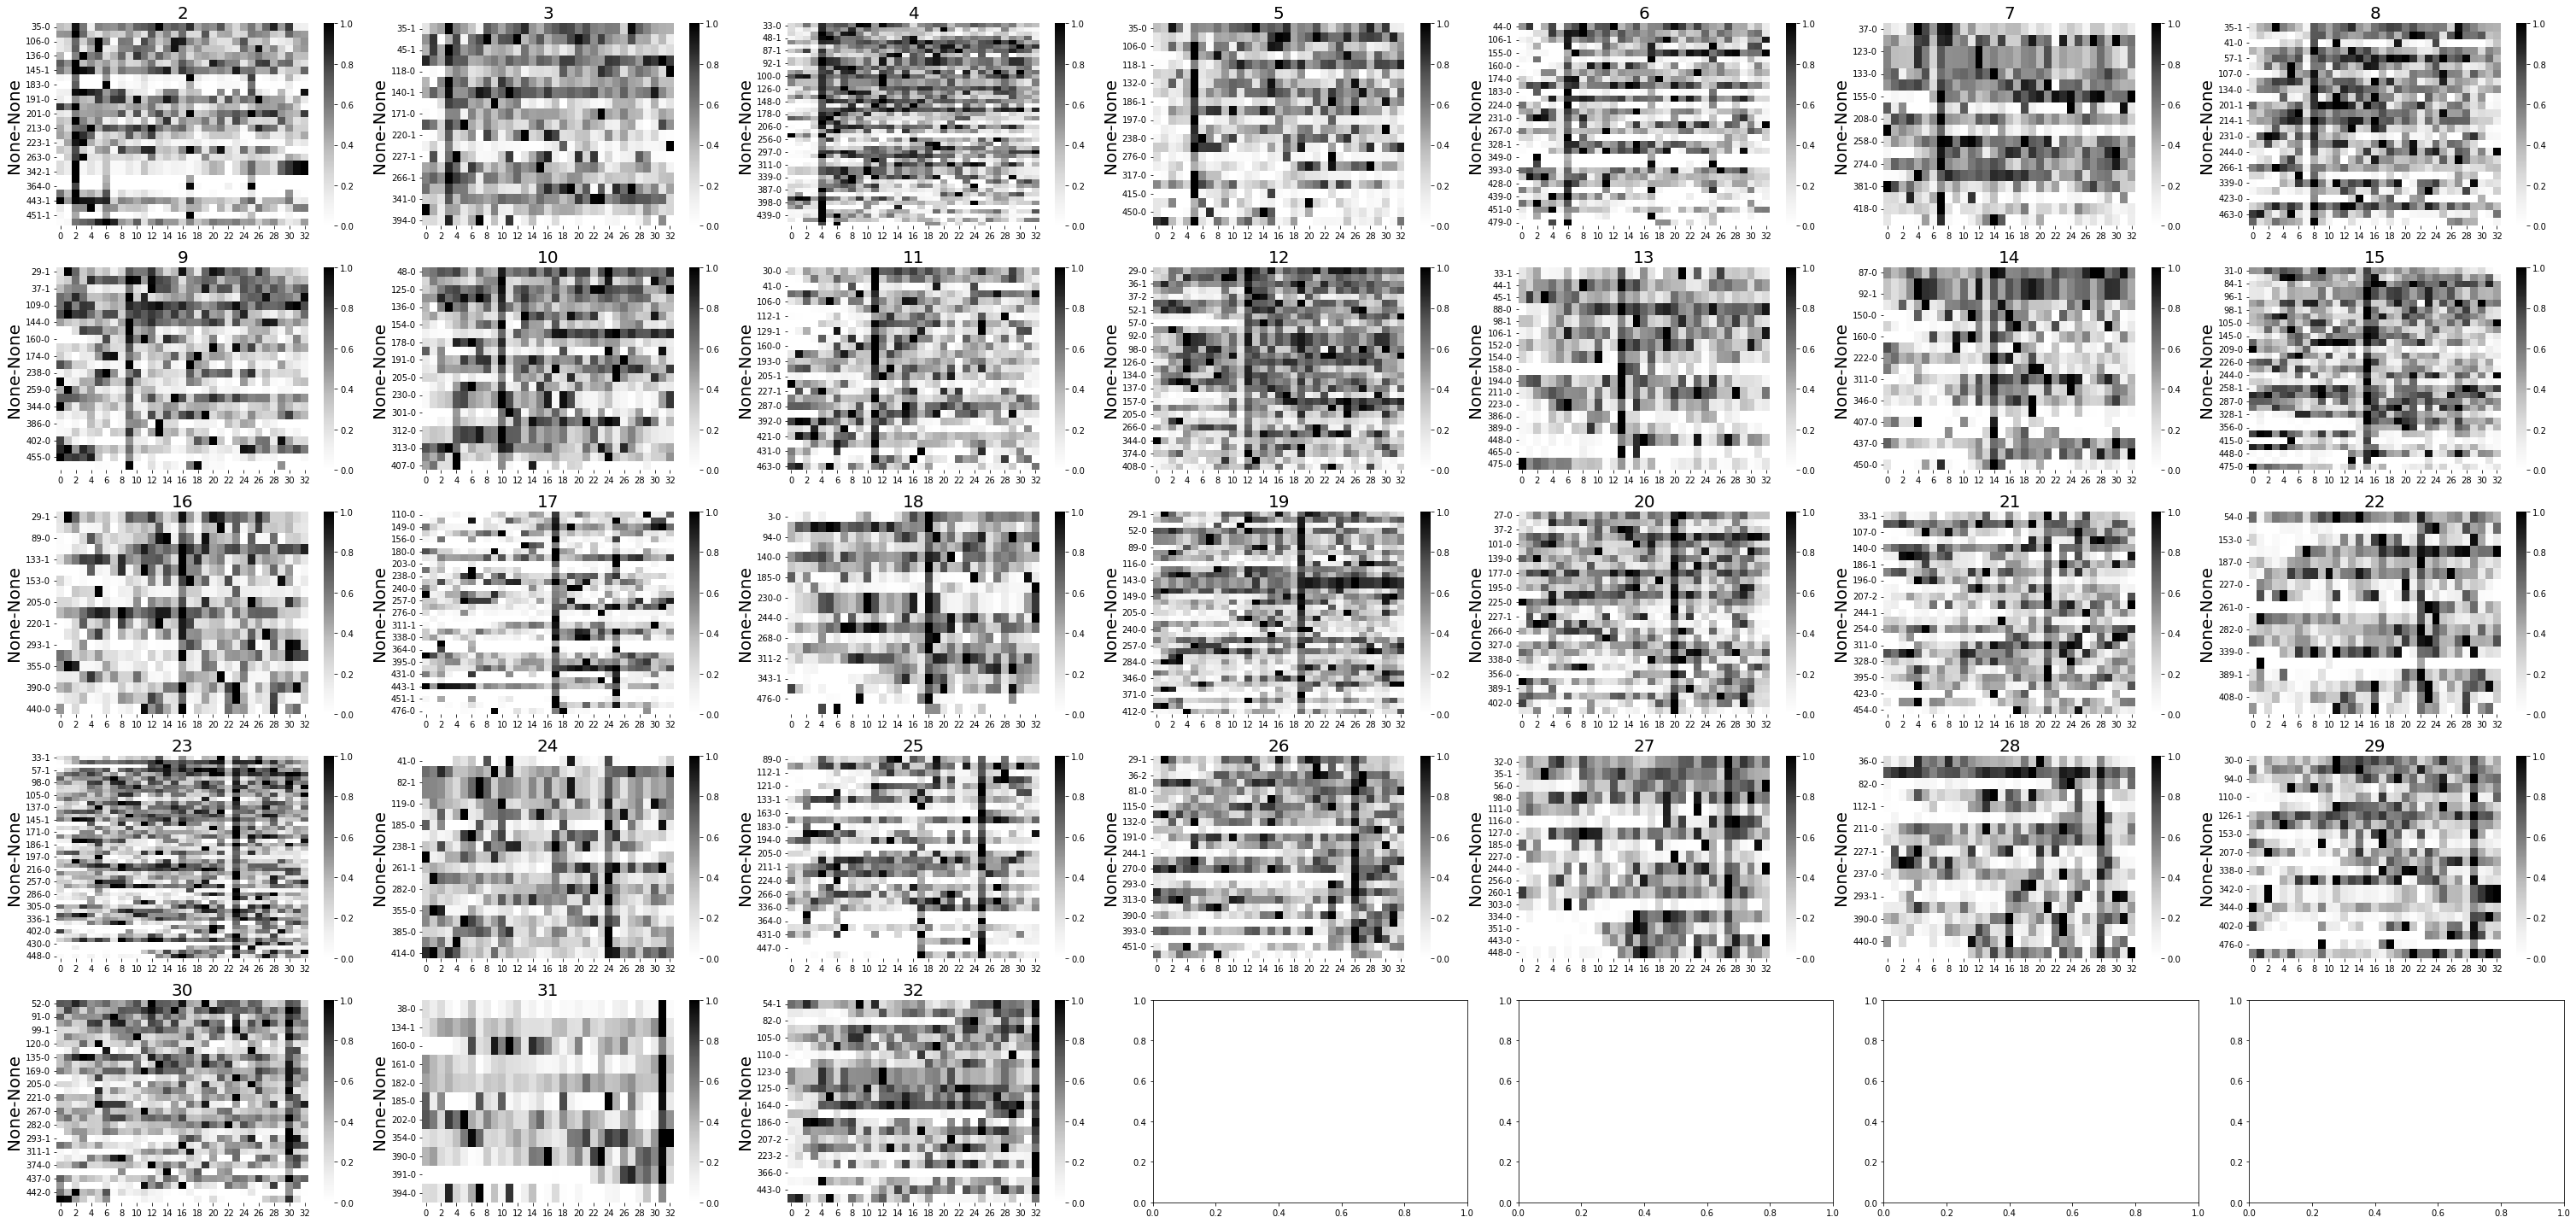

In [376]:
trialtype = (0,0)
pen = 'raw'
tosweep_key = 'switch_magnitude'
tosweep_val = 0.4
changes=changes_df_all.loc[0].loc[(*trialtype,pen,tosweep_key,tosweep_val),:]
inds_d = cpa.get_inds_switch_sametrial_sorted(changes)
fig,axs=cpp.plot_fields_switching_each_trial(X_to_be_analyzed['raw'][trialtype],inds_d.loc[1])

In [377]:
fig.savefig(os.path.join(data_dir_full,'py_figures','switch_analysis','coswitching_ex_raw.pdf'),bbox_inches='tight')

In [409]:
anysig=(sig_l_all['on']==1).loc[(slice(None),0),:].groupby(level=(0,1,2,3,4,5)).apply(lambda x:x.any(axis=1).values[0])

In [417]:
anysig_sum=anysig.sum(level=(1,3,4,5))


/tmp/ipykernel_263915/3618744935.py:1: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  anysig_sum=anysig.sum(level=(1,3,4,5))


In [425]:
tot_sess_n = anysig.loc[(slice(None),0,slice(None),0.1,'high_thresh',0.3)].shape[0]

In [426]:
anysig_ratio = anysig_sum / tot_sess_n

In [430]:
anysig_ratio_unstack = anysig_ratio.unstack(level=1).loc[0]

<AxesSubplot:ylabel='None-None'>

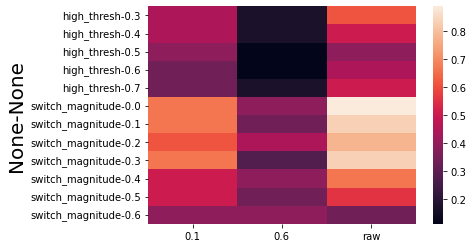

In [432]:
sns.heatmap(anysig_ratio_unstack[[0.1,0.6,'raw']])

In [421]:
anysig_sum.loc[0,0.1].

high_thresh       0.3     8
                  0.4     8
                  0.5     7
                  0.6     6
                  0.7     6
switch_magnitude  0.0    12
                  0.1    12
                  0.2    11
                  0.3    12
                  0.4     9
                  0.5     9
                  0.6     7
dtype: int64

In [398]:
for k,val in gpb:
    val

In [401]:
val.any(axis=1)

8  0  1.0  raw  switch_magnitude  0.6    False
dtype: bool